# Install, imports, etc.

In [1]:
!pip install -U https://github.com/NeuroTechX/moabb/archive/master.zip
!pip install braindecode
!wget -O feature_extraction.py https://raw.githubusercontent.com/skyli42/CSC413S2021-Team-22/master/feature_extraction.py 


     \ 798kB 20.9MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 645kB 15.3MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 27.4MB 103kB/s 
     |████████████████████████████████| 6.9MB 20.6MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 133kB 60.4MB/s 
     |████████████████████████████████| 6.8MB 50.8MB/s 
     |████████████████████████████████| 4.1MB 53.1MB/s 
  Created wheel for moabb: filename=moabb-0.3.0-cp37-none-any.whl size=116149 sha256=52fa0b02764e79974b736b6543407b1c3062fa40d185c7d6d9be7a49b13a7357
  Stored in directory: /tmp/pip-ephem-wheel-cache-m11wofsu/wheels/6b/6e/4c/947a2af13ece2bbe3681f59407109fd25f32aa27ca09a27808
Successfully built moabb
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.2.1 which is incompatible.
ER

In [2]:
from feature_extraction import feature_extract
from braindecode.datasets.bbci import  BBCIDataset
from braindecode.datasets.moabb import MOABBDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd    
import mne
from moabb.datasets import BNCI2014001
from moabb.paradigms import (LeftRightImagery, MotorImagery,
                             FilterBankMotorImagery)
from braindecode.datasets.base import BaseDataset, BaseConcatDataset
from braindecode.datautil.windowers import (create_fixed_length_windows,)
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split

from scipy.signal import welch, spectrogram
from scipy.ndimage.interpolation import shift
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import cohen_kappa_score, recall_score, precision_score


# Gathering + Preprocessing Data

In [3]:
code_dict = {'feet':0, 'left_hand':1, 'right_hand':2, 'tongue':3}

def XY_toTorch(X, Y, device):
  # print(X.shape)
  newX = torch.Tensor(X).reshape(X.shape[0], X.shape[1]*X.shape[2], X.shape[3])
  newY = torch.Tensor(Y).long()
  return newX.to(device), newY.to(device)

def reshape_X(X):
  return X.transpose(1, 2).transpose(0, 1)

def create_Loaders(subjects, opts, seed=1): 
  
  X_train, y_train, X_val, y_val, X_test, y_test = feature_extract("BNCI2014001", subjects, opts.window_size, opts.augmentation_factor, opts.augmentation_noise, seed=seed) 

  # X_train = X_train[..., 5:15]
  # X_val = X_val[..., 5:15]
  # X_test = X_test[..., 5:15]

  X_train, y_train = XY_toTorch(X_train, y_train, opts.device)
  X_val, y_val = XY_toTorch(X_val, y_val, opts.device)
  X_test, y_test = XY_toTorch(X_test, y_test, opts.device)
  train = TensorDataset(X_train, y_train) 
  val = TensorDataset(X_val, y_val)
  test = TensorDataset(X_test, y_test)
  
  train = DataLoader(train, batch_size=opts.batch_size)
  val = DataLoader(val, batch_size=opts.batch_size)
  test = DataLoader(test, batch_size=opts.batch_size)
  return train, val, test, X_train.shape[2], X_train.shape[1]

# Model

In [4]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, n_timesteps, n_channels, n_heads, en_hidden, de_hidden, n_transformer_layers, n_outputs, dropout=0.5):
        super().__init__()
        self.n_timesteps = n_timesteps
        self.n_channels = n_channels

        self.pos_encoder = PositionalEncoding(n_channels, dropout)
        encoder_layers = TransformerEncoderLayer(n_channels, n_heads, en_hidden, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_transformer_layers)
        self.decoder = nn.Sequential(
                        nn.Linear(n_timesteps*n_channels, 2*de_hidden),
                        nn.ReLU(),
                        nn.Dropout(dropout),
                        nn.Linear(2*de_hidden, de_hidden),
                        nn.ReLU(),
                        nn.Linear(de_hidden, n_outputs)
                      )
        
        self.init_weights()

    def init_weights(self):
        initrange = 2.0
        for layer in self.decoder:
          if hasattr(layer, 'weight'):
            nn.init.zeros_(layer.weight)
            nn.init.uniform_(layer.weight, -initrange, initrange)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, None).transpose(0, 1).reshape(-1, self.n_timesteps*self.n_channels)
        output = self.decoder(output)
        return output

# Training Utilities


In [5]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)

def get_accuracy(model, data, device):
    preds = torch.empty(0).to(device)
    y_true= torch.empty(0).to(device)
    for X, y in data:
      pred = torch.argmax(model(reshape_X(X)),1)
      preds = torch.cat((preds, pred))
      y_true = torch.cat((y_true, y))
    kappa_score = cohen_kappa_score(preds.cpu(), y_true.cpu())
    precision = precision_score(y_true.cpu(), preds.cpu(), average='macro')
    recall = recall_score(y_true.cpu(), preds.cpu(), average='macro')
    return torch.sum((preds==y_true).long()).item()/len(preds), kappa_score, precision, recall

def compute_loss(data, model, criterion, optimizer, scheduler, opts):
    losses = []
    for X, y in data:
        outputs = model(reshape_X(X))
        # print(outputs)
        loss = criterion(outputs, y)
        losses.append(loss.item())
        ## training if an optimizer is provided
        if optimizer:
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          scheduler.step()
          # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    return losses

In [6]:
def training_loop(train, val, encoder, criterion, optimizer, scheduler, opts):

    best_val_loss = 1e6
    train_losses = []
    val_losses = []
    
    mean_train_losses = []
    mean_val_losses = []

    early_stopping_counter = 0
    
    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]['lr'] *= opts.lr_decay
        
        train_loss = compute_loss(train, encoder, criterion, optimizer, scheduler, opts)
        val_loss = compute_loss(val, encoder, criterion, None, None, opts)

        mean_train_loss = np.mean(train_loss)
        mean_val_loss = np.mean(val_loss)

        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter > opts.early_stopping_patience:
            print("Validation loss has not improved in {} epochs, stopping early".format(opts.early_stopping_patience))
            print("Obtained lowest validation loss of: {}".format(best_val_loss))
            return (mean_train_losses, mean_val_losses)

        print("Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f}".format(epoch, mean_train_loss, mean_val_loss))
        train_losses += train_loss
        val_losses += val_loss

        mean_train_losses.append(mean_train_loss)
        mean_val_losses.append(mean_val_loss)

    print("Obtained lowest validation loss of: {}".format(best_val_loss))
    return (mean_train_losses, mean_val_losses)

In [7]:
def train(opts, train, val, test):
    encoder = TransformerModel(opts.timesteps, opts.channels, opts.heads, opts.en_hidden, opts.de_hidden, opts.transformer_layers, opts.outputs, opts.dropout)

    if opts.cuda:
        encoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(list(encoder.parameters()), lr=opts.learning_rate, weight_decay=opts.l2_reg)  
    # optimizer = torch.optim.SGD(encoder.parameters(), lr=opts.learning_rate, momentum= opts.momentum,weight_decay=opts.l2_reg)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=opts.lr_decay)

    try:
        losses = training_loop(train, val, encoder, 
                               criterion, optimizer, scheduler, opts)
    except KeyboardInterrupt:
        print('Exiting early from training.')
        return encoder, losses
      
    return encoder, losses

# Training

## Get data

In [8]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

options = AttrDict()
dict_op = {
  'augmentation_factor': 1,
  'augmentation_noise': 0.1,
  'window_size':75,
  'batch_size': 100,
  'device': device
}
options.update(dict_op)

train_data, val_data, test_data, n_timesteps, n_channels = create_Loaders([1], options, 24)

/usr/local/lib/python3.7/dist-packages/moabb/datasets/download.py:52: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, osp.join(osp.expanduser("~"), "mne_data"))


48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 

## Train

In [9]:
dict_op = {
  'nepochs':1000,
  'learning_rate':0.1,
  'lr_decay':0.999,
  'l2_reg': 0.0001,
  'momentum': 0.9,
  'en_hidden':400, 
  'de_hidden': 400,
  'timesteps': n_timesteps,
  'channels': n_channels,
  'heads': 4,
  'transformer_layers': 12,
  'outputs': 4,
  'dropout': 0.1,
  'cuda':True,
  'early_stopping_patience': 100
}
options.update(dict_op)
model, loss = train(options, train_data, val_data, test_data)
print("Train Accuracy: {}, Train Kappa: {}, Train Precision: {}, Train Recall: {}".format(*get_accuracy(model, train_data, device)))
print("Val Accuracy: {}, Val Kappa: {}, Val Precision: {}, Val Recall: {}".format(*get_accuracy(model, val_data, device)))

Moved models to GPU!
Epoch:   0 | Train loss: 703171.600 | Val loss: 239026.070
Epoch:   1 | Train loss: 266909.859 | Val loss: 167559.688
Epoch:   2 | Train loss: 97305.844 | Val loss: 61748.494
Epoch:   3 | Train loss: 60256.947 | Val loss: 23943.024
Epoch:   4 | Train loss: 19034.979 | Val loss: 6609.297
Epoch:   5 | Train loss: 12218.180 | Val loss: 9665.341
Epoch:   6 | Train loss: 8779.949 | Val loss: 9862.020
Epoch:   7 | Train loss: 8377.884 | Val loss: 8854.910
Epoch:   8 | Train loss: 6493.881 | Val loss: 5916.672
Epoch:   9 | Train loss: 5318.562 | Val loss: 3261.124
Epoch:  10 | Train loss: 3910.838 | Val loss: 3318.490
Epoch:  11 | Train loss: 2745.020 | Val loss: 1372.961
Epoch:  12 | Train loss: 1810.456 | Val loss: 876.226
Epoch:  13 | Train loss: 1012.732 | Val loss: 835.796
Epoch:  14 | Train loss: 878.579 | Val loss: 484.156
Epoch:  15 | Train loss: 473.498 | Val loss: 461.013
Epoch:  16 | Train loss: 389.355 | Val loss: 325.327
Epoch:  17 | Train loss: 294.121 | Val

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 0, 'Epoch')

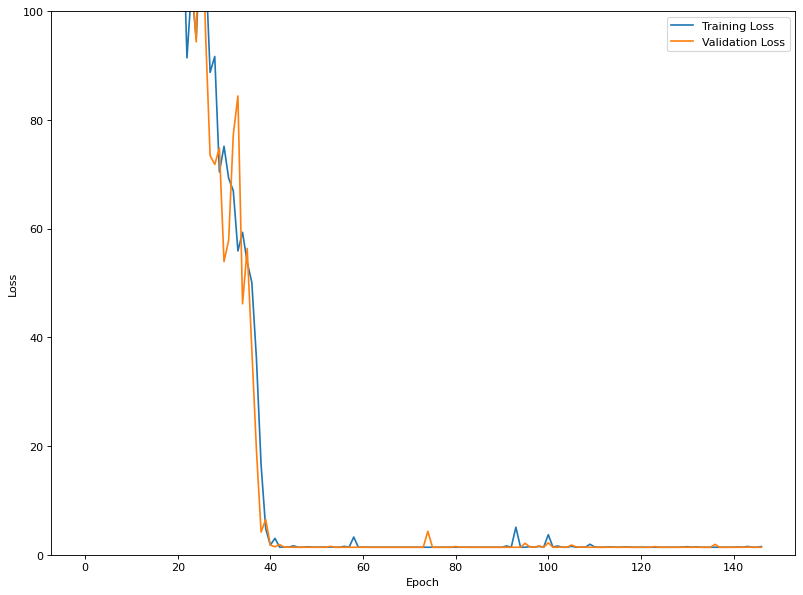

In [10]:
plt.figure(figsize=(12, 9), dpi=80)
train_loss, val_loss = loss
plt.ylim(0, 100)
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [11]:
print("Test Accuracy: {}, Test Kappa: {}, Test Precision: {}, Test Recall: {}".format(*get_accuracy(model, test_data, device)))

Test Accuracy: 0.20689655172413793, Test Kappa: 0.0, Test Precision: 0.05172413793103448, Test Recall: 0.25


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
